2025-07-15 18:48:06,819	INFO worker.py:1564 -- Connecting to existing Ray cluster at address: 10.0.0.55:6379...
2025-07-15 18:48:06,820	INFO worker.py:1582 -- Calling ray.init() again after it has already been called.
/home/cavadini/figaro-on-rl4cc/.figaro-rl4cc-venv/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:493: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/cavadini/figaro-on-rl4cc/.figaro-rl4cc-venv/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLogg

Iteration 0: reward=-16.640102016317435
Iteration 1: reward=-16.363392803899465
Iteration 2: reward=-15.655163787506572
Iteration 3: reward=-14.909603882328645
Iteration 4: reward=-14.157333286615053
Iteration 5: reward=-12.62014389863288
Iteration 6: reward=-11.014134686543379
Iteration 7: reward=-9.27187440651944
Iteration 8: reward=-7.588400259635311
Iteration 9: reward=-5.8847167855017855
Iteration 10: reward=-4.433678548613351
Iteration 11: reward=-3.154528917454993
Iteration 12: reward=-2.3822846643456117
Iteration 13: reward=-1.868739554464078
Iteration 14: reward=-1.6879481631086168
Iteration 15: reward=-1.6705659239754809
Iteration 16: reward=-1.6545119265467156
Iteration 17: reward=-1.6554817629067988
Iteration 18: reward=-1.6285385271780146
Iteration 19: reward=-1.6302849140486677
Iteration 20: reward=-1.5991326328253006
Iteration 21: reward=-1.5780751387913505
Iteration 22: reward=-1.5274597643889203
Iteration 23: reward=-1.538103331841632
Iteration 24: reward=-1.5205448383

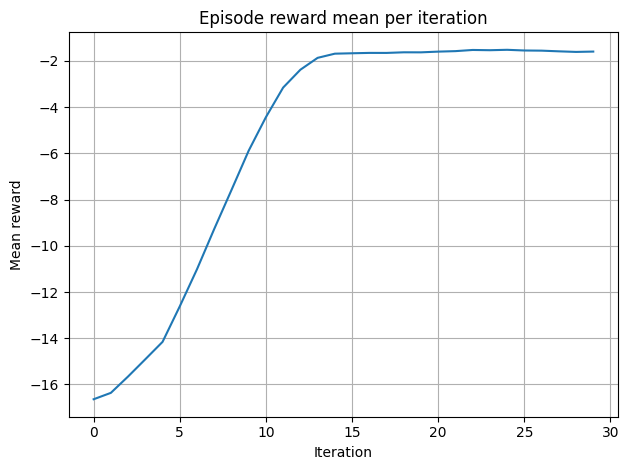

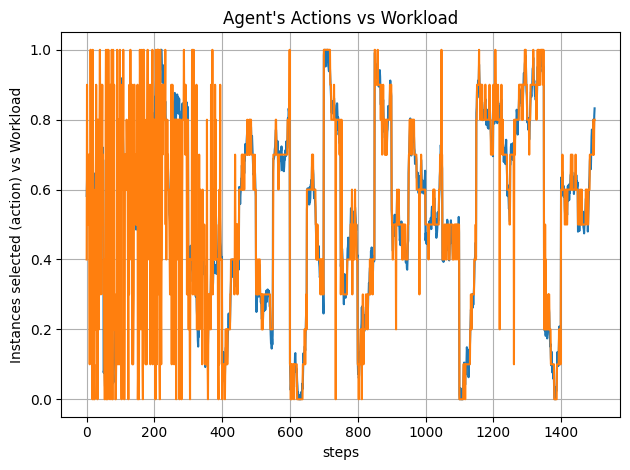

In [2]:
import os
import numpy as np
import cloudpickle
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
import matplotlib.pyplot as plt

import ray
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.env.env_context import EnvContext
from ray.rllib.policy.sample_batch import SampleBatch, MultiAgentBatch
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env  # ✅ Required

import torch

# -------- Custom Env --------
class ScalingEnv(gym.Env):
    def __init__(self, config: EnvContext = {}):
        self.max_instances = config.get("max_instances", 10)
        self.observation_space = Box(low=0.0, high=1.0, shape=(5,), dtype=np.float32)
        self.action_space = Discrete(self.max_instances + 1)
        self.step_count = 0
        self.max_steps = config.get("max_steps", 50)
        self.curr_obs = self._random_obs()

    def _random_obs(self):
        n_instances = np.random.randint(1, self.max_instances + 1)
        return {
            "n_instances": n_instances / self.max_instances,
            "pressure": np.random.uniform(0, 1),
            "queue_length_dominant": np.random.uniform(0, 1),
            "utilization": np.random.uniform(0, 1),
            "workload": np.random.uniform(0, 1),
        }

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0
        self.curr_obs = self._random_obs()
        return self._dict_to_obs(self.curr_obs), {}

    def _dict_to_obs(self, d):
        return np.array([d[k] for k in ["n_instances", "pressure", "queue_length_dominant", "utilization", "workload"]], dtype=np.float32)

    def step(self, action):
        self.step_count += 1

        n_instances = float(action)
        eps = 1e-3
        workload = np.clip(self.curr_obs["workload"], 0.0, 1.0)
        denom = max(n_instances / self.max_instances, eps)
        utilization = np.clip(workload / denom, 0.0, 1.0)
        pressure = np.clip(utilization + np.random.normal(0, 0.05), 0.0, 1.0)
        queue = np.clip(workload - utilization + np.random.normal(0, 0.05), 0.0, 1.0)

        reward = -abs(workload - n_instances / self.max_instances)
        workload = np.clip(workload + np.random.uniform(-0.05, 0.05), 0.0, 1.0)

        self.curr_obs = {
            "n_instances": n_instances / self.max_instances,
            "pressure": pressure,
            "queue_length_dominant": queue,
            "utilization": utilization,
            "workload": workload
        }

        if np.any(np.isnan(list(self.curr_obs.values()))):
            reward = -10.0
            self.curr_obs["workload"] = 0.5

        terminated = False
        truncated = self.step_count >= self.max_steps
        return self._dict_to_obs(self.curr_obs), reward, terminated, truncated, {}

# -------- Register Env -------- ✅
register_env("scaling_env", lambda config: ScalingEnv(config))

# -------- Train & Save Agent --------
def save_checkpoint(algo: Algorithm, iteration: int) -> str:
    save_dir = os.path.join("/home/cavadini/figaro-on-rl4cc/src/production_agents/DQN", f"checkpoints/{iteration}")
    os.makedirs(save_dir, exist_ok=True)

    # Save full RLlib algorithm state
    algo_state = {
        "algorithm_class": algo.__class__,
        "config": algo.config.to_dict(),
        "state": algo.get_state()
    }

    try:
        replay_buffer = algo.local_replay_buffer
        if replay_buffer:
            algo_state["replay_buffer_state"] = replay_buffer.get_state()
            print("✅ Replay buffer state saved.")
    except AttributeError:
        print("⚠️ No replay buffer found, skipping.")

    # Save RLlib state using cloudpickle
    state_path = os.path.join(save_dir, "algo_state.pkl")
    with open(state_path, "wb") as f:
        cloudpickle.dump(algo_state, f)
    print(f"✅ Checkpoint saved to {state_path}")

    # Save PyTorch model weights separately
    model_path = os.path.join(save_dir, "policy_model_weights.pt")
    policy = algo.get_policy()
    torch.save(policy.model.state_dict(), model_path)
    print(f"✅ PyTorch model weights saved to {model_path}")

    return save_dir

def train_agent():
    ray.init(ignore_reinit_error=True, include_dashboard=False)

    config = (
        DQNConfig()
        .environment("scaling_env", env_config={"max_instances": 10, "max_steps": 50})
        .framework("torch")
        .training(lr=1e-3, train_batch_size=64)
        .rollouts(num_rollout_workers=0)
        .resources(num_gpus=0)
        .debugging(log_level="ERROR")
    )

    algo = config.build()
    rewards = []
    workload_action_pairs = []
    all_observations = []

    for i in range(30):
        result = algo.train()
        print(f"Iteration {i}: reward={result['episode_reward_mean']}")
        rewards.append(result["episode_reward_mean"])
        
        env = ScalingEnv({"max_instances": 10, "max_steps": 50})
        obs, _ = env.reset()
        terminated = False
        truncated = False
        while not (terminated or truncated):
            workload = obs[4]
            action = algo.compute_single_action(obs)
            workload_action_pairs.append((workload, action/10))
            obs, _, terminated, truncated, _ = env.step(action)
            all_observations.append(obs)

    checkpoint_path = save_checkpoint(algo, i)
    print(f"Checkpoint saved at {checkpoint_path}")
    ray.shutdown()

    # Plot reward curve
    plt.plot(rewards)
    plt.title("Episode reward mean per iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Mean reward")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Plot workload vs action
    workloads, actions = zip(*workload_action_pairs)
    plt.figure()
    plt.plot(workloads)
    plt.plot(actions)
    plt.title("Agent's Actions vs Workload")
    plt.xlabel("steps")
    plt.ylabel("Instances selected (action) vs Workload")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return rewards, workload_action_pairs, all_observations

final_rewards, final_workload_action_pairs, all_observations = train_agent()



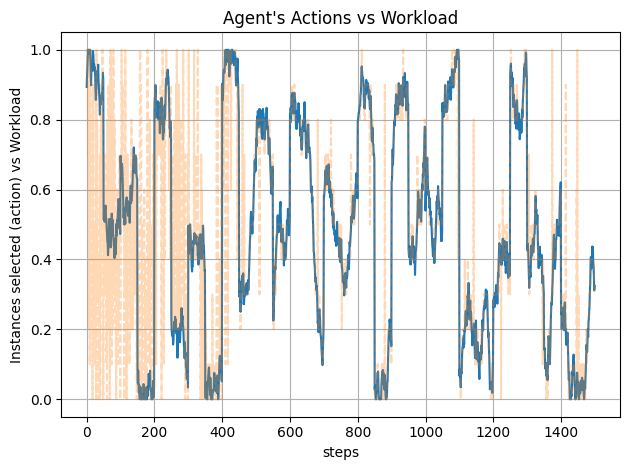

In [6]:
workloads, actions = zip(*final_workload_action_pairs)
plt.figure()
plt.plot(workloads, label='Workload')
plt.plot(actions, label='Actions', linestyle='--', alpha=0.3)
plt.title("Agent's Actions vs Workload")
plt.xlabel("steps")
plt.ylabel("Instances selected (action) vs Workload")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

In [4]:
#save all_observations to json
import json
all_observations = [obs.tolist() for obs in all_observations]  # Convert numpy arrays to lists
print(all_observations[:5])  # Print first 5 observations for verification
with open("all_observations.json", "w") as f:
    json.dump(all_observations, f)

[[0.8999999761581421, 1.0, 0.0, 0.9930195212364197, 0.919563889503479], [1.0, 0.8726623058319092, 0.0, 0.919563889503479, 0.9518949389457703], [1.0, 0.97255939245224, 0.0, 0.9518949389457703, 0.9788495302200317], [1.0, 0.9945715069770813, 0.0993802398443222, 0.9788495302200317, 1.0], [0.699999988079071, 0.9706788659095764, 0.030666658654808998, 1.0, 1.0]]
